In [1]:
from os import path
from matplotlib_venn import venn2, venn3
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Author:
Simon Hackl, 28.02.2021

#### Project:
Elaboration of a best practice for hybrid and long read de novo assembly of bacterial genomes utilizing Illumina and Oxford Nanopore Technologies reads

---

This notebook is used to analyze the results of the `S10_SNVdiscovery.sh` script and the manual SNV discovery runs of `DNAdiff` and `mauve` on the CFT073 unicycler (hybrid) and trycycler (+ medaka) assemblies. In order to use this notebook please ensure that all result files were generated and stored in the directories as it is described in the respective scripts.

---

####  Extracting SNV position information from the respective reports.

The following three methods are used to extract information about the SNV positions from the respective reports. As a result a dictionary will be created that stores the reference and called alternative base accessible via the position of the call. Additional information on the input formats for these methods can be found below:
- VCF file format: https://samtools.github.io/hts-specs/VCFv4.2.pdf
- DNAdiff SNP report: http://mummer.sourceforge.net/manual/ (`show-snps` section)
- Mauve SNP report: http://gensoft.pasteur.fr/docs/Mauve/2.3.1/mauve_user_guide.pdf (page 23 and 24)

In [2]:
def extractVCF( filepath, DP, QUAL ) :
    ''' Extracts positions and base calls from a VCF file.
    
    Parameters
    ----------
    filepath : str
        Specifies the path of .vcf file.
        
    DP : int
        Only reports positions with a read coverage higher or equal to the passed value.
    
    QUAL : int
        Only reports positions with a reported quality higher or equal to the passed value.
    '''
    with open( filepath, "r" ) as file :
        line = file.readline( )
        SNPs = { }
        sampleNames = dict( 
            enumerate( 
                path.basename( filepath ).split( "-" )[ 0 ].split( "~" ), 
                start = 0
            )
        )
        while line :
            if line.startswith("#") : # Skip comment lines
                line = file.readline( )
                continue
            else :
                data = line.split("\t") # Else each column is accessed by splitting the line at tabulator symbols.
                genotypeData = data[9:]
                genotypeData[-1] = genotypeData[-1].strip( )
                quality = float( data[ 5 ] )
                depth = int( data[ 7 ].split( ";" )[ 0 ].split( "=" )[ 1 ] )
                # If the specified quality and coverage depth thresholds are fullfilled, the positions are stored.
                if quality >= QUAL and depth >= DP :
                    SNPs[ int( data[ 1 ] ) ] = {
                        "REF" : data[ 3 ],
                        "ALT" : data[ 4 ],
                        "GT" : { }
                    }
                    if len( genotypeData ) > 1 and genotypeData[ 0 ] == genotypeData[ 1 ] :
                        SNPs[ int( data[ 1 ] ) ][ "GT" ][ sampleNames[ 0 ] ] = genotypeData[ 0 ]
                        SNPs[ int( data[ 1 ] ) ][ "GT" ][ sampleNames[ 1 ] ] = genotypeData[ 1 ]
                    else :   
                        for entry in genotypeData :
                            sampleNr = genotypeData.index( entry )
                            SNPs[ int( data[ 1 ] ) ][ "GT" ][ sampleNames[ sampleNr ] ] = entry
                            
            line = file.readline( )
    return SNPs

In [3]:
def extractDNAdiff( filepath ) :
    ''' Extracts positions and base calls from a DNAdiff .snps file.
    
    Parameters
    ----------
    filepath : str
        Specifies the path of DNAdiff .snps file.
    '''
    with open( filepath, "r" ) as file :
        line = file.readline( )
        SNPs = { }
        while line :
            data = line.split( "\t" )
            pos = int( data[ 0 ] )
            ref = data[ 1 ]
            alt = data[ 2 ]
            if ref == "." or alt == "." : # If the position represents an indel, it is skipped.
                pass
            else :
                SNPs[ pos ] = { 'REF': ref, 'ALT': alt }
            line = file.readline( )
    return SNPs

In [4]:
def extractMauve( filepath ) :
    ''' Extracts positions and base calls from a Mauve SNPs report.
    
    Parameters
    ----------
    filepath : str
        Specifies the path of Mauve .txt file generated with the Export SNPs option.
    '''
    with open( filepath, "r" ) as file :
        line = file.readline( )
        skipHeader = True
        SNPs = { }
        while line :
            if skipHeader :
                skipHeader = False
            else :
                data = line.split( "\t" )
                pos = int( data[ 3 ] )
                ref = data[ 0 ][ 0 ]
                alt = data[ 0 ][ 1 ]
                if ref == "." or alt == "." or ref == "-" or alt == "-" : # If the position represents an indel, it is skipped.
                    pass
                else :
                    SNPs[ pos ] = { 'REF': ref, 'ALT': alt }
            line = file.readline( )
    return SNPs

---

#### Parsing the output files into dictionaries
With the methods above the respective report files can be parsed into dictionaries. For the `.vcf` files a depth of coverage of at least 40 and a quality of at least 50 are used as cutoff values to store a position.

In [5]:
info_bcftools_s = extractVCF( "./results/SNVDiscovery/CFT073/bcftools/SRR8482585-bcftools.vcf", 40, 50 )
info_bcftools_l = extractVCF( "./results/SNVDiscovery/CFT073/bcftools/SRR8494940-bcftools.vcf", 40, 50 )
info_bcftools_ls = extractVCF( "./results/SNVDiscovery/CFT073/bcftools/SRR8494940~SRR8482585-bcftools.vcf", 40, 50 )
info_dnadiff_uh = extractDNAdiff( "./results/SNVDiscovery/CFT073/dnadiff/unicycler~hybrid-dnadiff.snps" )
info_dnadiff_tm = extractDNAdiff( "./results/SNVDiscovery/CFT073/dnadiff/trycycler_medaka-dnadiff.snps" )
info_mauve_uh = extractMauve( "./results/SNVDiscovery/CFT073/mauve/unicycler~hybrid-mauve.snps" )
info_mauve_tm = extractMauve( "./results/SNVDiscovery/CFT073/mauve/trycycler_medaka-mauve.snps" )

---
#### Definition of a reference SNV set
As no reliable set of reference SNVs is present for evaluating the SNVs detected with the above mentioned approches, a consensus calling of the SNVs discovered with DNAdiff and mauve using the unicycler hybrid assembly and the SNVs called with the short reads using bcftools is conducted.
This approach, however, implies that the short reads and hybrid assemblies yield more likely SNVs than the other approaches. 

To do this all SNVs sharing the position and alternative base call by any two of the three sets is considered as a reference SNV. The therewith obtained SNVs are stored in a dictionary like the info_... variables before.

In [6]:
# Define a method to convert the `info_...` dictionaries into a set of tuples, each with a position and alternative base entry.
toPosAlt = lambda dictionary : set( [ ( key, value[ 'ALT' ] ) for key, value in dictionary.items( ) ] )
# The reference SNVs can be computed as the union of all pairwise set intersections:

referenceSNVs = dict( )
for pos, alt in sorted( list( 
    ( toPosAlt( info_bcftools_s ) & toPosAlt( info_dnadiff_uh ) ) | \
    ( toPosAlt( info_bcftools_s ) & toPosAlt( info_mauve_uh ) ) | \
    ( toPosAlt( info_mauve_uh ) & toPosAlt( info_dnadiff_uh ) )
) ) :
    referenceSNVs[ pos ] = { 'ALT' : alt }

In addition the set of reference SNVs is visualized as a Venn diagramm relative to the three sets from which it was built in the following.

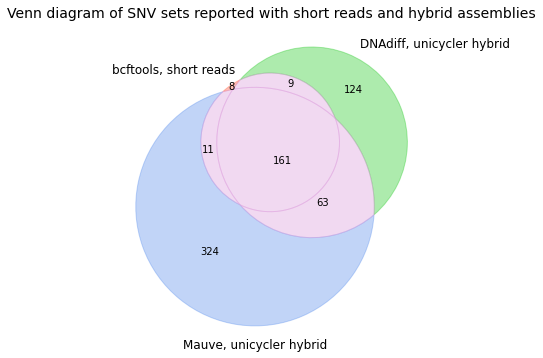

In [7]:
plt.figure( figsize = ( 6, 6 ) )
plt.title( "Venn diagram of SNV sets reported with short reads and hybrid assemblies", fontsize = 14 )
v = venn3( [ toPosAlt( info_bcftools_s ), toPosAlt( info_dnadiff_uh ), toPosAlt( info_mauve_uh ) ],
           ( "bcftools, short reads", "DNAdiff, unicycler hybrid", "Mauve, unicycler hybrid" )
         )
v.get_patch_by_id('100').set_color('tomato')
v.get_patch_by_id('010').set_color('limegreen')
v.get_patch_by_id('001').set_color('cornflowerblue')
v.get_patch_by_id('110').set_color('plum')
v.get_patch_by_id('101').set_color('plum')
v.get_patch_by_id('011').set_color('plum')
v.get_patch_by_id('111').set_color('plum')

---

#### Computing pairwise intersections of all SNV sets
In the following an overview of the pairwise intersection of each SNV set will be depicted.

In [8]:
def getIntersection2D( sets ) :
    ''' Computes an 2D list in which each cell i,j contains the size of the intersection between set
    i and set j. If j > i the dummy value `np.nan` will be stored to avoid duplicates.
    
    Parameters
    ----------
    sets : list
        A list containing sets.
    '''
    info2D = [ ]
    setsIndexList = range( len( sets ) )
    for i in setsIndexList :
        info2D.append( [ ] )
        for j in setsIndexList :
            if j <= i :
                info2D[ i ].append( len( sets[ i ].intersection( sets[ j ] ) ) )
            else :
                info2D[ i ].append( np.nan )
    return info2D

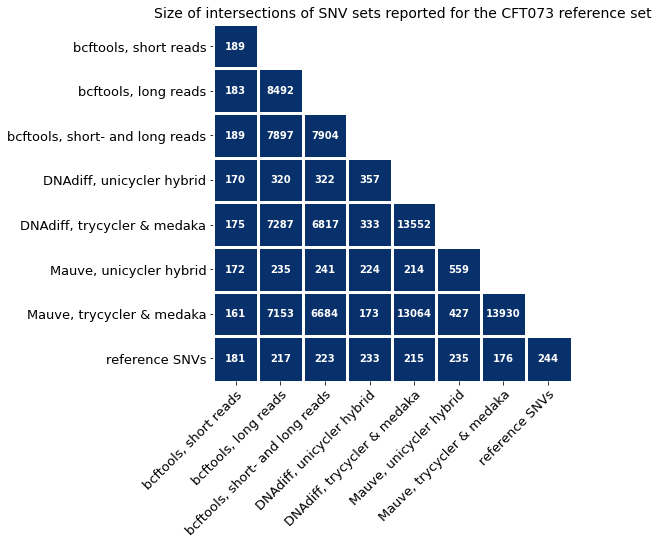

In [9]:
# To simplify the computation the following lists store each SNV info set and an corresponding label,
# as well as the reference SNV set computed before.
infos = [ info_bcftools_s, info_bcftools_l, info_bcftools_ls, info_dnadiff_uh, info_dnadiff_tm, info_mauve_uh, info_mauve_tm, referenceSNVs ]
info_labels = [ "bcftools, short reads", "bcftools, long reads", "bcftools, short- and long reads", "DNAdiff, unicycler hybrid", "DNAdiff, trycycler & medaka", "Mauve, unicycler hybrid", "Mauve, trycycler & medaka", "reference SNVs" ]

# Each SNV info set is converted into a set of tuples, each storing the reference position and alternative base.
# These sets are used as input for the `getIntersection2D` method.
info2D = getIntersection2D( [ set( [ ( key, value[ 'ALT' ] ) for key, value in i.items( ) ] ) for i in infos ] )

fig, ax = plt.subplots( figsize = ( 6, 6 ) )
fig.tight_layout()
im = ax.imshow( info2D , cmap="Blues", vmin=1, vmax=10**2 ) # Change the vmin and vmax values for coloring to achieve a constant color.
plt.setp( ax.xaxis.get_majorticklabels( ), rotation=45, ha="right", rotation_mode="anchor" )
plt.setp( ax.yaxis.get_majorticklabels( ), rotation=0, ha="right", rotation_mode="anchor" )
plt.title( "Size of intersections of SNV sets reported for the CFT073 reference set", fontsize = 14 )

info2Dsize = len( info2D )
for i in range( info2Dsize ) :
    for j in range( info2Dsize ) :
        #if j == i + 1 :
        #    TP = info2D[ info2Dsize - 1 ][ i ]
        #    FP = info2D[ i ][ j - 1 ] - info2D[ info2Dsize - 1 ][ i ]
        #    text = ax.text(j, i, round( ( TP / ( TP + FP ) ), 2 ), ha="center", va="center", color="black", fontweight="bold")
        if not np.isnan( info2D[ i ][ j ] ) :
            # Each cell of the heatmap is labeled with the size of the intersection.
            text = ax.text(j, i, info2D[ i ][ j ], ha="center", va="center", color="w", fontweight="bold")

# Set predefined labels.
ax.set_xticks( np.arange( len( info_labels ) ) )
ax.set_yticks( np.arange( len( info_labels ) ) )        
ax.set_xticklabels( info_labels, fontsize = 13 )
ax.set_yticklabels( info_labels, fontsize = 13 )

# Draw a white grid for better separation of the single fields:
ax.grid( True, which="minor", color="w", linestyle='-', linewidth=1 )
ax.tick_params( which="minor", bottom=False, left=False )
for i in range( len( info_labels ) ) :
    plt.vlines( i - 0.5, -0.5, len( info_labels ) - 0.5, color="w", linewidth=3 )
    plt.hlines( i - 0.5, -0.5, len( info_labels ) - 0.4, color="w", linewidth=3 )

# Remove axis bars.
for edge, spine in ax.spines.items():
    spine.set_visible(False)

---

#### Detailed evaluation of the bcftools sets
To evaluate more in detail how the use of long reads may influence SNV discovery (relative to the use of short reads alone), the sets computed with `bcftools` are analyzed further in the following:
- It is checked to which extend the called genotype (reference or alternative) of the reference SNVs detected with bcftools is in agreement between using short- and long reads alone.
- For the SNVs detected with bcftools that are not contained in the set of reference SNVs it is checked to which extend the reported genotype likelihoods are in agreement between the short- and long read sets alone.

To investigate the first point, a Pandas dataframe will be constructed in the following that stores
1. the alternative base called by bcftools using both, short- and long reads, or a single read set.
2. the genotype (alternative or reference) reported based on the short- and long read information of the bcftools reports using both or a single read set.
for each SNV position that is contained in the reference set.

In [10]:
# Definition of a dictionary storing rows for the dataframe. The first row defined the column labels.
columns = { 'index' : [ 'bcftools_ls.GT_s', 'bcftools_ls.GT_l', 'bcftools_ls.ALT', 'bcftools_s.GT', 'bcftools_s.ALT', 'bcftools_l.GT', 'bcftools_l.ALT' ] }
# Definition of a helper function to extract the genotype (0 for reference, 1 for alternative) from an bcftools info dictionary.
getGenotype = lambda info, sampleID : info[ key ][ 'GT' ][ sampleID ].split( ":" )[ 0 ]
# For each reference SNVs a list is created that stores the data from the bcftools info dictionaries in the same order as the column labels were defined.
for key, value in referenceSNVs.items( ) :
    newRow = [ ]
    if key in info_bcftools_ls : # Extract values from the bcftools report using both sets.
        newRow.append( getGenotype( info_bcftools_ls, 'SRR8482585' ) )
        newRow.append( getGenotype( info_bcftools_ls, 'SRR8494940' ) )
        newRow.append( info_bcftools_ls[ key ][ 'ALT' ] )
    else : # If a position is not contained, store the reference genotype (i.e. as no variation was detected).
        newRow.append( '0' )
        newRow.append( '0' )
        newRow.append( '-' ) # Use '-' as symbol for indicating no information about an alternative base.
    if key in info_bcftools_s : # Extract values from the bcftools report using short reads only.
        newRow.append( getGenotype( info_bcftools_ls, 'SRR8482585' ) )
        newRow.append( info_bcftools_s[ key ][ 'ALT' ] )
    else :
        newRow.append( '0' )
        newRow.append( '-' )
    if key in info_bcftools_l : # Extract values from the bcftools report using long reads only.
        newRow.append( getGenotype( info_bcftools_ls, 'SRR8494940' ) )
        newRow.append( info_bcftools_l[ key ][ 'ALT' ] )
    else :
        newRow.append( '0' )
        newRow.append( '-' )
    columns[ key ] = newRow # Add extracted information as new row.
    
# Create a dataframe from the rows constructed above.
bcftoolsData = pd.DataFrame( columns )
# We define the index/number of each row as its index.
bcftoolsData.set_index( "index", inplace = True )
# Set a multi index for each column.
index = pd.MultiIndex.from_tuples( [ c.split( "." ) for c in bcftoolsData.index ] )
bcftoolsData.set_index( index, inplace = True )
# Sort the rows to yield genotype information on top.
bcftoolsData.sort_index( level = 1, inplace = True )
#  Next we sort the columns based on the called geno types. This will allow a visualization of all SNVs that exhibit the same genotype pattern. 
bcftoolsData.sort_values( 
    [ ( 'bcftools_s', 'GT'), ( 'bcftools_l', 'GT'), ( 'bcftools_ls', 'GT_s'), ( 'bcftools_ls', 'GT_l') ],
    axis = 1, inplace = True
)
bcftoolsData.head( )

,,274240,389074,1164808,1165672,2142952,2142957,2359139,3994735,4207736,4207768,...,4873866,4874536,4874554,4874581,4874618,4987964,4988540,4998140,5020584,5021317
bcftools_l,ALT,-,-,-,-,-,-,-,-,-,-,...,C,C,C,T,C,G,C,A,A,G
bcftools_ls,ALT,-,-,-,-,-,-,-,-,-,-,...,C,C,C,T,C,G,C,A,A,G
bcftools_s,ALT,-,-,-,-,-,-,-,-,-,-,...,C,C,C,T,C,G,C,A,A,G
bcftools_l,GT,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
bcftools_s,GT,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


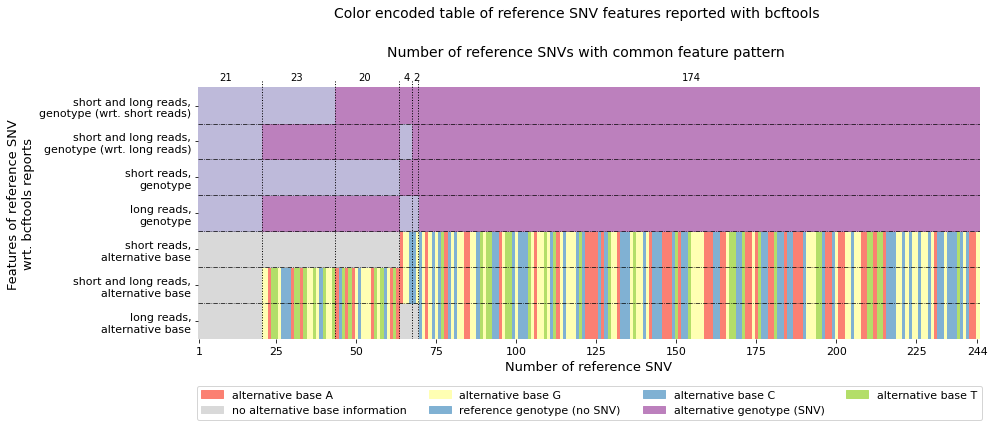

In [11]:
# For visualization we have to replace the stored string values with numbers. The numbers are chosen to yield a well distinguishable coloring with colormap 'Set3'
plotData = bcftoolsData \
    .replace( '1', 10 ) \
    .replace( '0', 3 ) \
    .replace( '.', 3 ) \
    .replace( 'A', 4 ) \
    .replace( 'C', 5 ) \
    .replace( 'G', 2 ) \
    .replace( 'T', 7 ) \
    .replace( '-', 9 )
# Generate a heatmap-like plot: Each column of the dataframe constructed above will be visualized by a color encoding of its content. 
fig, ax = plt.subplots( figsize = ( 14, 5  ) )
ax.pcolor( plotData, cmap = "Set3", vmin = 1, vmax = 12 )

# Construct x-axis tick labels and title.
ax.set_xlim( 0, bcftoolsData.shape[ 1 ] )
xticks = [ 1, 25, 50, 75, 100, 125, 150, 175, 200, 225, 244 ]
ax.set_xticks( [ i - 0.75 for i in xticks ] )
ax.set_xticklabels( xticks, fontsize = 11 )
ax.set_xlabel( "Number of reference SNV", fontsize = 13 )

# Construct y-axis tick labels and title.
ax.set_yticks( np.arange( 0.5, bcftoolsData.shape[ 0 ], 1 ) );
ax.set_yticklabels( 
    [ "long reads,\nalternative base",
      "short and long reads,\nalternative base",
      "short reads,\nalternative base",
      "long reads,\ngenotype",
      "short reads,\ngenotype",
      "short and long reads,\ngenotype (wrt. long reads)",
      "short and long reads,\ngenotype (wrt. short reads)" ],
    fontsize = 11
)
ax.set_ylabel( "Features of reference SNV\nwrt. bcftools reports", fontsize = 13 )

# Plot horizontal lines to distinguish every feature of single SNVs better.
ax.hlines( np.arange( 1, len( bcftoolsData.index ) ), 0, bcftoolsData.shape[ 1 ], color = "black", linestyle="-.", linewidth = 0.7 )

# The group borders define a position i for which the i+1-th SNV starts to show a differing genotype pattern.
# The borders were extracted visually from a first visualization without borders.
groupBorders = [ 20, 43, 63, 67, 69 ] 
ax.vlines( [ b - 0.25 for b in groupBorders ], 0, 7.2, color = "black", linestyle = ":", linewidth = 1 )

# Remove axis bars.
for edge, spine in ax.spines.items():
    spine.set_visible(False)

# Label secondary x axis (on top) with the sizes of each group.
lastSize = 0
groupBorders.append( 243 )
for gb in groupBorders :
    gb = gb + 1
    size = gb - lastSize
    text = ax.text( lastSize + ( size / 2 ), 7.3, size, ha="right", va="center", color="black" )
    lastSize = gb
text = ax.text( 121, 8, "Number of reference SNVs with common feature pattern", ha="center", va="center", color="black", fontsize = 14 )

# Lastly, generate a legend to describe the color encoding:
plt.legend( handles = [ mpatches.Patch( color = plt.get_cmap('Set3')(3), label = 'alternative base A'),
                       mpatches.Patch( color = plt.get_cmap('Set3')(8), label = 'no alternative base information'),
                       mpatches.Patch( color = plt.get_cmap('Set3')(1), label = 'alternative base G'),
                       mpatches.Patch( color = plt.get_cmap('Set3')(4), label = 'reference genotype (no SNV)'),
                       mpatches.Patch( color = plt.get_cmap('Set3')(4), label = 'alternative base C'),
                       mpatches.Patch( color = plt.get_cmap('Set3')(9), label = 'alternative genotype (SNV)'),
                       mpatches.Patch( color = plt.get_cmap('Set3')(6), label = 'alternative base T') ], 
           fontsize = 11, bbox_to_anchor=(1.01, -0.15), ncol=4 );

plt.suptitle( "Color encoded table of reference SNV features reported with bcftools", x = 0.5, y = 1.05, fontsize = 14 );

To investigate the second point, a histogram showing the distribution of normalized Phred scaled genotype likelihoods reported by the short- and long read only bcftools report for all non reference SNV positions is plotted.

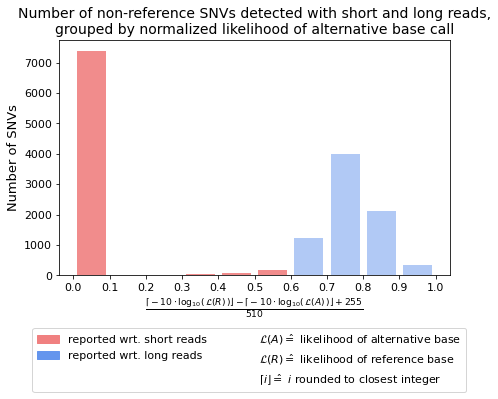

In [12]:
# The following four lists will store the reference and alternative base likelihoods for all relevant SNV positions.
genotypeLikelihoodShortreadsRef = [ ]
genotypeLikelihoodShortreadsAlt = [ ]
genotypeLikelihoodLongreadsRef = [ ]
genotypeLikelihoodLongreadsAlt = [ ]
for key, value in info_bcftools_ls.items( ) :
    if key not in referenceSNVs :
        genotypeLikelihoodShortread = info_bcftools_ls[ key ][ "GT" ][ "SRR8482585" ].split( ":" )[ 1 ].split( "," )
        genotypeLikelihoodLongread = info_bcftools_ls[ key ][ "GT" ][ "SRR8494940" ].split( ":" )[ 1 ].split( "," )
        genotypeLikelihoodShortreadsRef.append( int( genotypeLikelihoodShortread[ 0 ] ) )
        genotypeLikelihoodShortreadsAlt.append( int( genotypeLikelihoodShortread[ 1 ] ) )
        genotypeLikelihoodLongreadsRef.append( int( genotypeLikelihoodLongread[ 0 ] ) )
        genotypeLikelihoodLongreadsAlt.append( int( genotypeLikelihoodLongread[ 1 ] ) )
        
# Definition of a helper function to unity-normalize the difference of reported Phred scaled genotype likelihoods.
normalizeLikelihoods = lambda likelihoodsRef, likelihoodsAlt : [ ( ( r - a ) + 255 ) / ( 2 * 255 ) for r, a in zip( likelihoodsRef, likelihoodsAlt ) ]

# Start preparing the plot.
plt.figure( figsize=( 7, 7 / 1.618 ) )

# Label x-axis with formula used to calculate x-values
plt.xlabel( r'$\frac{ \lceil-10\cdot \log_{10}(\,{\cal L}(R)\,)\rfloor - \lceil-10\cdot \log_{10}(\,{\cal L}(A)\,)\rfloor + 255}{510} $', fontsize = 13 )
plt.xticks( np.arange( 0, 1.1, 0.1 ), fontsize = 11 )
plt.ylabel( "Number of SNVs", fontsize = 13 )
plt.yticks( fontsize = 11 )

# Plot histograms of collected data.
plt.hist( normalizeLikelihoods( genotypeLikelihoodShortreadsRef, genotypeLikelihoodShortreadsAlt ), bins = np.arange( 0, 1.1, 0.1 ), rwidth=0.8, label = "reported for short reads", color = "lightcoral", alpha = 0.9 );
plt.hist( normalizeLikelihoods( genotypeLikelihoodLongreadsRef, genotypeLikelihoodLongreadsAlt ), bins = np.arange( 0, 1.1, 0.1 ), rwidth=0.8, label = "reported for long reads", color = "cornflowerblue", alpha = 0.5 );

plt.title( "Number of non-reference SNVs detected with short and long reads,\ngrouped by normalized likelihood of alternative base call", fontsize = 14 )

# Legend explains symbols used in xlabel and colors.
plt.legend( handles = [ mpatches.Patch( color = 'lightcoral', label = 'reported wrt. short reads'),
                       mpatches.Patch( color = 'cornflowerblue', label = 'reported wrt. long reads'),
                       mpatches.Patch( color = 'white', label = ""),
                       mpatches.Patch( color = 'white', label = r'${\cal L}(A) \hat{=}$ likelihood of alternative base'),
                       mpatches.Patch( color = 'white', label = r'${\cal L}(R) \hat{=}$ likelihood of reference base'),
                       mpatches.Patch( color = 'white', label = r'$\lceil i \rfloor \hat{=}$ $i$ rounded to closest integer') ],
           fontsize = 11, bbox_to_anchor=(1.055, -0.2), ncol=2 );